# Capstone Project 1 - Predicting Bridge Conditions in Georgia

Can we identify deficient bridges before they are inspected, using information that doesn't require a costly inspection to obtain? This is the goal of this capstone project. Who stands to benefit from this? The Department of Transportation. Simply put, this predictive model will allow earlier detection of bridge deficiency issues and will also allow the DOT's to more effectively triage their bridge inspection resources, which like all economic units, are finite. You as the citizen taxpayer stand to benefit from safer bridge infrastructure and more efficient allocation of your hard earned money in taxes as well.

Let's see what we can find by analyzing the FHWA Bridge Inventory for the state of Georgia, which represents a census of all bridges in the state. We will collect data from other sources to improve our analysis. Part one will be to explore the data, visualize and develop hypotheses, and use traditional statistical techniques to get as much insight into the dataset as possible. Part two will be to develop our machine learning model to predict bridge conditions. Initial screening of features for developing hypotheses will be done using domain knowledge and the constraints of our problem, mentioned previously. Along the way let's keep in mind what is happening, that bridges in the USA get inspected with a period at most 2 years, and sometimes less if the bridge condition is sufficiently bad to warrant higher frequency inspections. These inspections grade the deck, superstructure, and substructure of a bridge on a discrete scale from 0 to 9, and these condition grades are what we want to predict and understand better. Additionally we will try to predict Sufficiency Rating, which is another bridge health metric that is based on condition rating and is a continuous variable.

## Import packages and define functions

In [1]:
#This project has been worked in conjunction with the guidance found in the 
#Recording and Coding Guide for the Structure Inventory and Appraisal of the Nations Bridges on the FHWA website
import time
start = time.time()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import scipy.stats as stats
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
current_year = 2017

In [2]:
def checkdf(df,columnlist):
    """check each column of df in columnlist for null values and print how many"""
    na_columns = []
    for column in column_list:
        if data[column].isna().sum() > 0:
            na_columns.append(column)
            print('Null values in',column,':',data[column].isnull().sum())
    # return list of columns with null values
    return na_columns

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    """Draw bootstrap replicate"""
    
    boot_sample = np.random.choice(data,size=len(data),replace=True)
    
    return func(boot_sample)

def conf_int(data, conf=95):
    """Create bootstrap confidence interval of mean"""
    
    x1 = (100-conf) / 2
    x2 = 100 - x1
    boot_samples = draw_bs_reps(data, np.mean, size=10000)
    
    return np.percentile(boot_samples, [x1,x2])

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
      Thanks to Zhiya Zuo for this function code
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=classes)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    ax.grid('off')
    return ax

## Import Bridge and Elevation data

We think that including elevation data for all of our bridges will help explain it's condition, so we use data previously downloaded from the Open Elevation API from MapQuest (yes, MapQuest is still around).

In [4]:
#FHWA Bridge Inventory
filedata = pd.read_csv('GA17.txt')
#Open Elevation data
elevations = pd.read_csv('elevations.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,5,31,75,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean and Merge Data

Before we can get useful insights from the data, it must be cleaned. Though tedious, this step is absolutely crucial.

In [5]:
#The FHWA inventory includes data on both bridges and culverts. We don't care for culverts, so we drop them
data = filedata.loc[filedata['CULVERT_COND_062']=='N']
num_bridges_orig, num_columns = data.shape

#Add an 'AGE' column for our predictive model, based on the last year included in the dataset, 2017
data = data.assign(AGE = pd.Series(current_year - data.loc[:,'YEAR_BUILT_027']))

In [6]:
#Limit dataset to bridges built on or after 1900 due to material standards
data = data[data['YEAR_BUILT_027']>1900]
#Limit dataset further to bridges under 400 ft long, most are under 200 ft
data = data[data['STRUCTURE_LEN_MT_049']<=400]

#Gather columns of interest, Features and Response variables are both contained in column_list
column_list =['LAT_016','LONG_017','STRUCTURE_KIND_043A','YEAR_BUILT_027','AGE','STRUCTURE_LEN_MT_049','elevation','DESIGN_LOAD_031','ROADWAY_WIDTH_MT_051','ADT_029','PERCENT_ADT_TRUCK_109','DEGREES_SKEW_034','HORR_CLR_MT_047','DECK_COND_058','SUPERSTRUCTURE_COND_059','SUBSTRUCTURE_COND_060','SUFFICIENCY_RATING']

In [7]:
filedata.shape

(14863, 137)

\-- Interestingly, the GDOT website says that there are 14,750 bridges in Georgia as of 2018. Their definition must include culverts but must also neglect a few of the structures in the FHWA inventory, which was 14,863 in 2017.

\-- We have excluded bridges built before ASTM standards were in place, to normalize the data, because
bridges built before then would have had inconsistent standards for material acceptance in the bridge.
ASTM was officially founded in 1898, so we choose a cutoff of 1900 to allow for adoption of the standard.

In [8]:
#Drop bridges for which no elevation data could be obtained
elevations = elevations[elevations['elevation']>=0]

#Merge elevations into main data set
elevations.drop('Unnamed: 0',axis=1,inplace=True)
data = data.merge(elevations, how='inner', on=['LAT_016','LONG_017'])

In [9]:
#Convert all columns to numeric values
for column in column_list:
    data[column] = pd.to_numeric(data[column],errors='coerce')
    data[column] = data[column].astype('float64')
#Convert Bridge Type code to string based on FHWA manual
#The manual makes a distinction between Concrete and Concrete Continuous, the same for Steel and Steel Continuous. 
#This is not an important distinction for our purposes and will be disregarded when converting the codes
codedict = {1:'Concrete',2:'Concrete',3:'Steel',4:'Steel',5:'Prestress',6:'Prestress',7:'Wood',8:'Masonry',9:'Alum./Iron'}
data['STRUCTURE_KIND_043A'] = data['STRUCTURE_KIND_043A'].map(codedict)
na_columns = checkdf(data,column_list)

Null values in STRUCTURE_KIND_043A : 2


In [10]:
def RateBridge(row,typ=3):
    minval = min(row['DECK_COND_058'],row['SUPERSTRUCTURE_COND_059'],row['SUBSTRUCTURE_COND_060'])
    if typ == 3:
        if minval <= 4:
            rating = 0
        elif minval >= 7:
            rating = 2
        else: 
            rating = 1
    else:
        if minval <=4:
            rating = 0
        else:
            rating = 1
    return rating
data['bridge_class3'] = data.apply(lambda row: RateBridge(row,typ=3),axis=1)
data['bridge_class2'] = data.apply(lambda row: RateBridge(row,typ=2),axis=1)

In [11]:
#Drop NA values from all columns identified in checkdf function
data = data.dropna(axis=0,subset=na_columns)

#The last 4 columns in the list are the variables to be predicted (response variables), the rest are features.
feature_list = column_list[:-4]
df_features = data[feature_list]
response_vars = data[column_list[-4:]]
bridge_count, feature_count = df_features.shape

print('')
print('Number of Bridges in Georgia (2017):',num_bridges_orig)
print('Number of Dataset Columns:',num_columns)
print('...')
print('Number of Bridges in Dataset:',bridge_count)
print('Number of Dataset Features:',feature_count)


Number of Bridges in Georgia (2017): 9198
Number of Dataset Columns: 137
...
Number of Bridges in Dataset: 8995
Number of Dataset Features: 13


## Visualize Data

\-- Now that we have a cleaned and wrangled dataset, we need to perform Exploratory Data Analysis in order to get more acquainted with our data. We will investigate visualizations, correlations, and summary statistics.

First step is to see the distribution of bridge types by material of the main structural elements, beams (the long things that hold the whole bridge up).

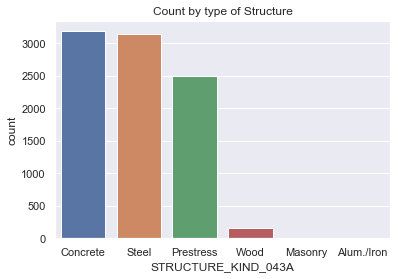

In [12]:
#Bridge Material type visualization
type_count = pd.DataFrame(data.groupby('STRUCTURE_KIND_043A').size(),columns=['Count']).sort_values(by='Count',ascending=True)
sns.set(style="darkgrid")
sns.countplot(x='STRUCTURE_KIND_043A',data=data)
plt.title('Count by type of Structure')
plt.show()

\-- As a Bridge Engineer, I expected **Prestressed Beams** to dominate the distribution. However, I've realized my own bias in this regared for a simple reason. These are the beams you usually see on the freeway and main highway bridges, however if we recognize that Georgia has a large rural population where bridges will be smaller and not carry as heavy traffic as an Interstate, then this makes sense.

Next let's see how bridge length is distributed in Georgia.

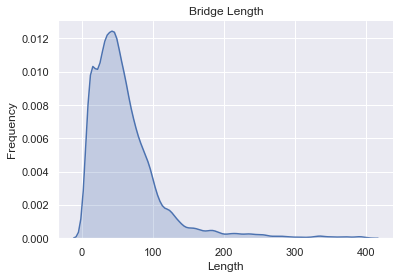

In [13]:
#seaborn distplot of structure length
ax = sns.distplot(data['STRUCTURE_LEN_MT_049'],hist=False,kde_kws={"shade": True})
ax.set(title='Bridge Length',xlabel = 'Length', ylabel = 'Frequency')
sns.set_style(style='darkgrid')
sns.despine(right=True)
plt.show()

In [14]:
data['STRUCTURE_LEN_MT_049'].describe()

count    8995.000000
mean       60.777221
std        51.026820
min         6.400000
25%        29.300000
50%        48.800000
75%        76.200000
max       398.700000
Name: STRUCTURE_LEN_MT_049, dtype: float64

\-- The median length of bridge in Georgia is shorter than I expected, but it's always more interesting when the data reveal insights that are cross to your expectations. Not every road is the interstate. This also makes sense when we see that the category of bridge with the highest count is regular reinforced concrete, which is limited in its maximum span compared to prestressed concrete.

We would like to know **how old** our bridges are, so let's visualize the distribution.

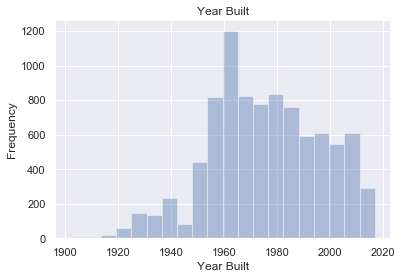

In [15]:
sns.distplot(data['YEAR_BUILT_027'],kde=False,bins=20)
plt.title('Year Built')
sns.despine(right=True)
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()

\-- Looks like there was a spike of bridges built in the 1960s. This almost certainly corresponds to passing of the Federal-Aid Highway Act of 1956 by President Eisenhower, https://www.fhwa.dot.gov/infrastructure/50interstate.cfm. It is very interesting to see a known historical event reflected in the data. In short, a lot of bridges in Georgia and the US will be approximately the same age as the baby boomer generation.

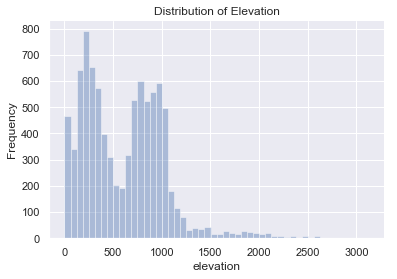

In [16]:
sns.distplot(data['elevation'], kde=False)
sns.despine(right=True)
plt.title('Distribution of Elevation')
plt.ylabel('Frequency')
plt.show()

Elevation is bi-modally distributed, which was not expected. I wonder why no one likes to build at elevation 500? We know that Atlanta is approximately between 900 ft and 1100 ft across the city, which could account for the spike around that elevation. This may indicate the bridges running down I-75 towards Macon and I-15 towards Savannah.

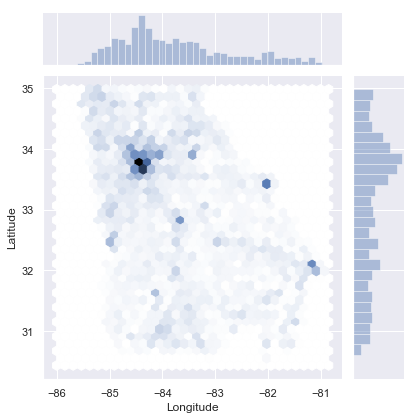

In [17]:
fig = sns.jointplot("long", "lat", data=data, kind="hex")
#plt.title('Geographic distribution of bridges in Georgia')
fig.ax_joint.set_xlabel('Longitude')
fig.ax_joint.set_ylabel('Latitude')
plt.show()

Here we have the general shape of Georgia, which is neat to see. Being familiar with the geography of the state, we can see concentrations of bridges in the major cities: Atlanta, Augusta, Columbus, Savannah, Macon, and Athens. That dead zone at the bottom corresponds to Okefenokee National Wildlife Refuge, apparently alligators don't like concrete.

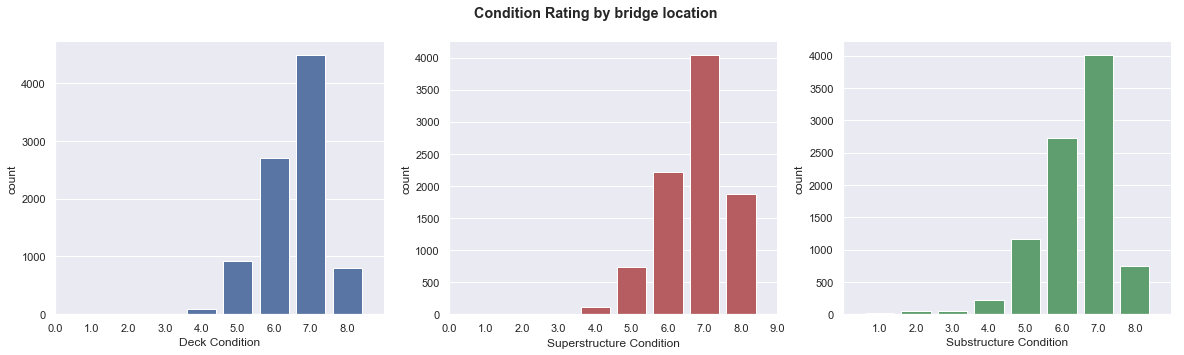

In [18]:
#Plot Bridge Condition for Deck, Superstructure, and Substructure
fig, axes = plt.subplots(ncols=3, nrows=1,figsize=(20,5))
sns.despine(right=True)
# Plot a simple histogram with binsize determined automatically
sns.countplot(data=data,x='DECK_COND_058', color="b", ax=axes[0])
sns.countplot(data=data,x='SUPERSTRUCTURE_COND_059', color="r", ax=axes[1])
sns.countplot(data=data,x='SUBSTRUCTURE_COND_060', color='g', ax=axes[2])
axes[0].set_xlim(0,data['DECK_COND_058'].max()+1)
axes[1].set_xlim(0,data['SUPERSTRUCTURE_COND_059'].max())
axes[2].set_xlim(-1,data['SUBSTRUCTURE_COND_060'].max())
axes[0].set_xlabel('Deck Condition')
axes[1].set_xlabel('Superstructure Condition')
axes[2].set_xlabel('Substructure Condition')
fig.suptitle('Condition Rating by bridge location', fontweight='bold')
plt.show()

Condition ratings are the values that inspectors give to each of three different parts of a bridge. It is a discrete measure of how well that part of the structure is able to perform its function. The three areas of interest are as follows.

1. Deck - What vehicles drive on directly
2. Superstructure - mostly beams that hold the deck up, as well as joints and bearings
3. Substructure - bent caps, columns, foundations that are accessible

Condition rating is assigned based on a discrete scale ranging from 9 (**excellent**) to 0 (**failed**), in increments of 1.

In [19]:
conditions = ['DECK_COND_058','SUPERSTRUCTURE_COND_059','SUBSTRUCTURE_COND_060']
for condition in conditions:
    print('')
    print(condition)
    print('Mean',round(data[condition].mean(),2))
    print('Std. Dev:',round(data[condition].std(),3))
    print('')


DECK_COND_058
Mean 6.55
Std. Dev: 0.852


SUPERSTRUCTURE_COND_059
Mean 6.75
Std. Dev: 0.951


SUBSTRUCTURE_COND_060
Mean 6.38
Std. Dev: 1.022



-- It appears that all 3 have approximately the same distribution shape and are close in their summary statistics. There is a pattern of increasing standard deviation going from the deck on top to the substructure on bottom. It is hard to see the in the histograms, but the numbers help illuminate what is going on. I wonder why the Substructure seems to be doing poorly compared to the other systems?

In [20]:
data.groupby('STRUCTURE_KIND_043A')['SUPERSTRUCTURE_COND_059'].mean().sort_values(ascending=False)

STRUCTURE_KIND_043A
Alum./Iron    8.000000
Prestress     7.481363
Concrete      6.594730
Steel         6.356304
Wood          5.950000
Masonry       5.500000
Name: SUPERSTRUCTURE_COND_059, dtype: float64

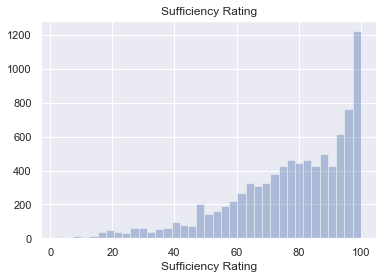

In [21]:
sns.distplot(data['SUFFICIENCY_RATING'],kde=False)
plt.title('Sufficiency Rating')
sns.set(style="white", palette="muted", color_codes=True)
plt.xlabel('Sufficiency Rating')
plt.show()

-- Sufficiency rating is a discontinued measure of bridge condition nationally, but is still used in Georgia. The sufficiency rating is a report card grade for a bridge. It is a calculated rating where 55% of the value is derived directly from the three condition ratings and the other 45% is calculated from the geometry and other bridge considerations.

In [22]:
data['SUFFICIENCY_RATING'].describe()

count    8995.000000
mean       77.095053
std        19.576019
min         2.000000
25%        65.800000
50%        81.000000
75%        93.700000
max       100.000000
Name: SUFFICIENCY_RATING, dtype: float64

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(0, 0.1)

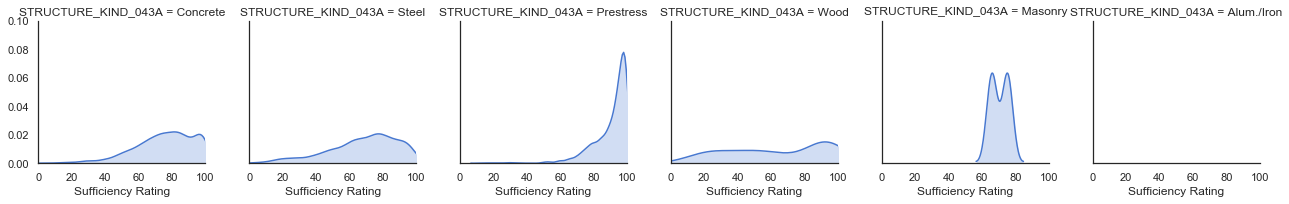

In [23]:
h = sns.FacetGrid(data, col='STRUCTURE_KIND_043A')
h.map(sns.distplot, 'SUFFICIENCY_RATING',hist=False,kde_kws={"shade": True}).set_xlabels('Sufficiency Rating')
plt.xlim(0, 100) 
plt.ylim(0, 0.1)

\-- It appears that Concrete and Steel have approximately the same distribution of sufficiency rating, and are both left skewed, however Prestress and Wood differ dramatically from the first two. Since Prestress is a newer implemented technology, the idstributions make sense. Wood seems to have the greatest spread, and the most percentage of deficient bridges, corresponding to Sufficiency rating of 50 or below.

In [24]:
data[data['STRUCTURE_KIND_043A']=='Prestress']['AGE'].describe()

count    2495.000000
mean       22.289379
std        13.686241
min         0.000000
25%        11.000000
50%        22.000000
75%        31.000000
max       111.000000
Name: AGE, dtype: float64

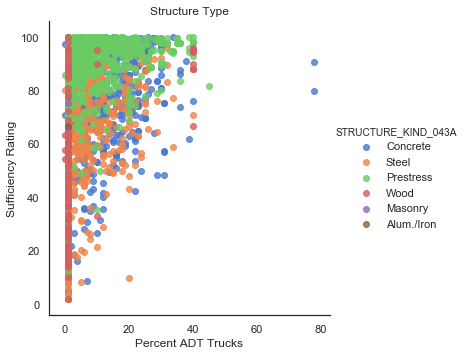

In [25]:
sns.lmplot(x='PERCENT_ADT_TRUCK_109',y='SUFFICIENCY_RATING',data=data,hue='STRUCTURE_KIND_043A',fit_reg=False)
plt.title('Structure Type')
plt.xlabel('Percent ADT Trucks')
plt.ylabel('Sufficiency Rating')
plt.show()

## Find Correlations

\-- We need to investigate the correlation relationships between our variables to understand the ways that some variables may influence, or be jointly influenced by, other factors in the dataset. We've seen some interesting distributions of individual variables, now we need to see how they interact with each other in order to develop hypotheses and later, build our predictive model. To do this neatly in one place, we will generate a heatmap first where the grid represents the correlation coefficients of the correlation between the two variables, denoted by both color and the value of the coefficient. We use spearman coefficient because some variables may not be linearly related.

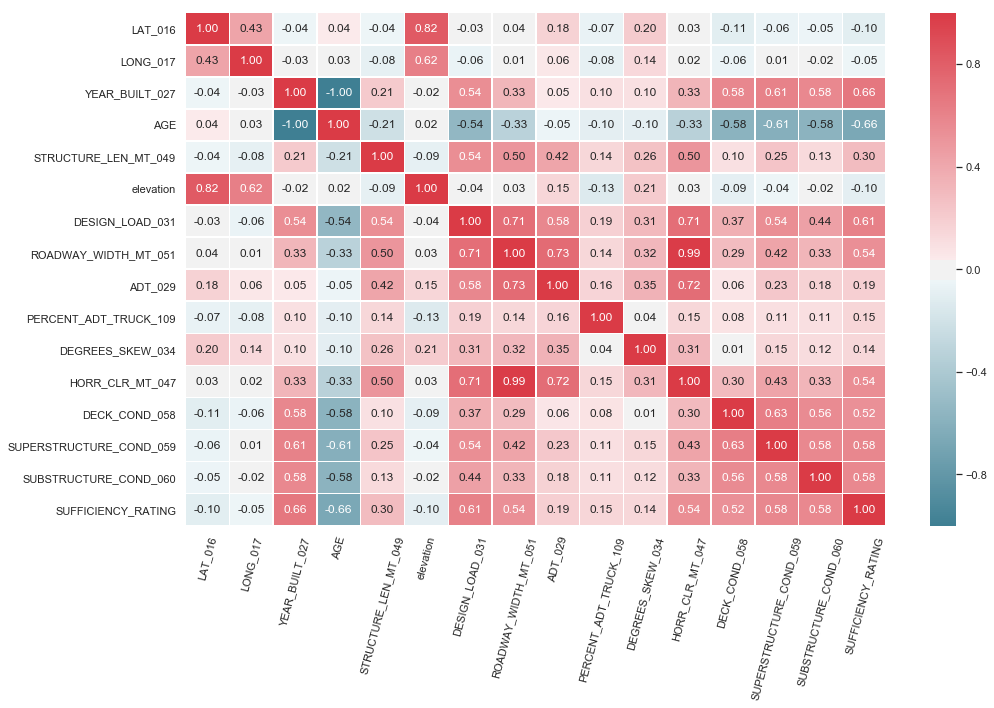

In [26]:
#Use spearman since some relationships may not be linear
heat = data[column_list].corr('spearman')
fig, ax = plt.subplots(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(heat, cmap=colormap, annot=True, fmt=".2f",linewidths=0.5)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

Some strong, interesting correlations
- Age <> Response Variables
- Horizontal Clearance <> Response Variables
- Design Load <> Response Variables
- Roadway Width <> Response Variables

Age seems to be the strongest predictor of bridge condition, but does not correlate strongly with any of the other feature variables. I propose that Age will be the most informative feature in our predictive model.

Elevation does not seem to have as strong a correlation as we had hoped, but that is simply what it is. It may still be useful for the machine learning model we will build.

Some features are correlated with each other and may need to be removed to build our predictive model.

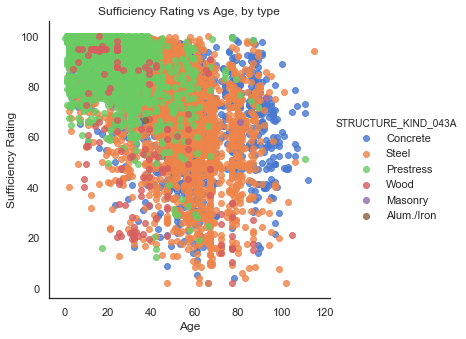

In [27]:
age_data = data.groupby('AGE').mean()
age_data = age_data.reset_index()
sns.lmplot(x='AGE',y='SUFFICIENCY_RATING',data=data,hue='STRUCTURE_KIND_043A',fit_reg=False)
plt.xlabel('Age')
plt.ylabel('Sufficiency Rating')
plt.title('Sufficiency Rating vs Age, by type')
plt.subplots_adjust(top=0.9)
plt.show()

It is interesting to note that prestress technology does not seem to have been widely used in Georgia until about 60 years ago, in the late 50s and 60s

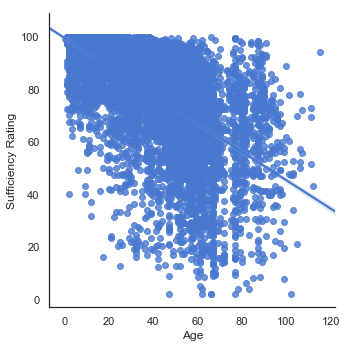

In [28]:
age_data = data.groupby('AGE').mean()
age_data = age_data.reset_index()
sns.lmplot(x='AGE',y='SUFFICIENCY_RATING',data=data,fit_reg=True)
plt.xlabel('Age')
plt.ylabel('Sufficiency Rating')
plt.show()

(0, 100)

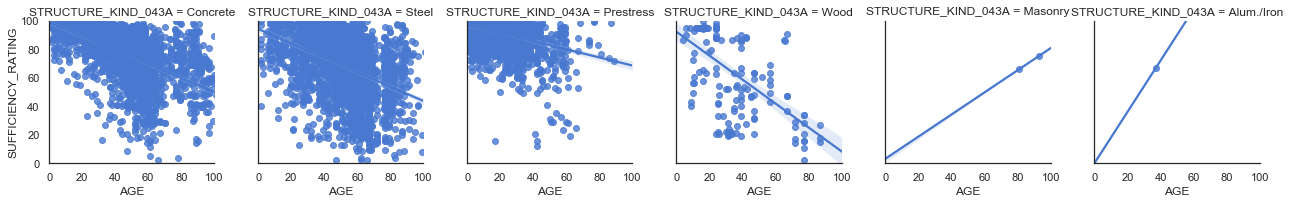

In [29]:
g = sns.FacetGrid(data, col="STRUCTURE_KIND_043A") 
g.map(sns.regplot, "AGE", "SUFFICIENCY_RATING") 
plt.xlim(0, 100) 
plt.ylim(0, 100)

As age increases, sufficiency rating goes down.

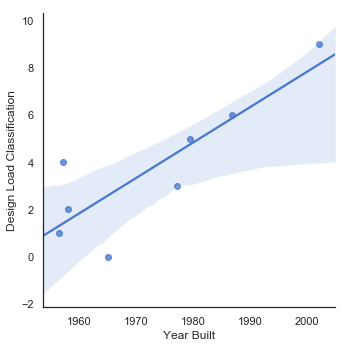

In [30]:
load_data = data.groupby('DESIGN_LOAD_031').mean()
load_data = load_data.reset_index()
sns.lmplot(x='YEAR_BUILT_027',y='DESIGN_LOAD_031',data=load_data)
plt.xlabel('Year Built')
plt.ylabel('Design Load Classification')
plt.show()

We know from domain knowledge that truck loads have increased over time, and since age correlates strongly with condition rating and sufficiency rating, I propose that Design Loading, which is shown here as a categorical number that increases as the load increases, will not be an important predictor for condition rating, since it is highly related to age. It will most likely not add new information since it is as correlated with age as it is any of the condition rating categories.

## Data Story Conclusion

**Data Story Conclusion**: So far, we've seen some surprising results (listed below). We have found that there are some interesting correlations between variables and we have verified historical events through EDA. We have characterized the dataset thoroughly through visualization, descriptive statistics, and correlations. From the EDA, we have a good grasp of the basic descriptive attributes of bridges in Georgia, such as their type, age, length, general condition, elevation, etc. We now are able to develop hypotheses below, which we will test with more formal methods later. Overall, there do appear to be features which will help to build an accurate machine learning model. First, let's review the surprises.

**Some surprises**:
1. Elevation is not significantly correlated with condition ratings.
2. Structure length is much shorter than expected. Most bridges in Georgia are not very long.
3. The adoption of presstressed concrete technology in Georgia bridges happened much later than expected.

**Some not so surprises**
- Age is highly predictive of bridge condition.

**Hypotheses**

- Hypothesis A: Age is the strongest predictor of bridge condition, across bridge types.
- Hypothesis B: Steel and Concrete are indistinguishable in their distribution of bridge conditions.
- Hypothesis C: There are differences in the mean condition rating by bridge location
- Hypothesis D: Many easily obtainable features of bridges are useful in predicting bridge condition.
- Hypothesis E: Design Load and elevation are not significant predictors of bridge condition.

# Hypothesis Testing

## Hypothesis A

Establish correlation between age and each condition rating with spearman r

Hypothesis test

**H0**: There is no relationship between age and condition rating

**Ha**: There is a relationship between age and condition rating


In [31]:
corr = np.empty(3,dtype='float')
p_corr_age = np.empty(3,dtype='float')
for index, item in enumerate(conditions):
    corr[index], p_corr_age[index] = stats.pearsonr(data['AGE'],data[item])
print(corr)
print(p_corr_age)

[-0.56088568 -0.5913647  -0.53717309]
[0. 0. 0.]


With p-values close to zero for all structure conditions, we reject the null hypothesis that there is no relationship between age and condition rating.

In [32]:
for index, item in enumerate(conditions):
    r, p, lo, hi = pearsonr_ci(data['AGE'],data[item],alpha=0.05)
    print(item,':',[lo,hi])
    print('P-Value:',p)


DECK_COND_058 : [-0.5748880564042593, -0.5465548875666929]
P-Value: 0.0
SUPERSTRUCTURE_COND_059 : [-0.6046413457526414, -0.5777595320211998]
P-Value: 0.0
SUBSTRUCTURE_COND_060 : [-0.5517144389538099, -0.5223052531045997]
P-Value: 0.0


The range of correlation is very tight for all three condition rating types. It appears that age has the strongest effect on the superstructure of a bridge. This could be due to accessibility issues, where compared to the deck of the abutments and piers, the bearings and the girders are hard to get access to for full maintenance.

## Hypothesis B

Now we will test Hypothesis B, that there is no difference in average condition rating for steel and concrete bridges. First we will see if there is a difference in the means, then in the distributions.

In [33]:
steel = data[data['STRUCTURE_KIND_043A'] == 'Steel']
concrete = data[data['STRUCTURE_KIND_043A'] == 'Concrete']
t = np.empty(3,dtype='float')
p_cond = np.empty(3,dtype='float')
for index, item in enumerate(conditions):
    t[index], p_cond[index] = stats.ttest_ind(steel[item],concrete[item])
    print(item, 'T-Statistic',round(t[index],2))
    print(item, 'P-Value',p_cond[index])
    print('')

DECK_COND_058 T-Statistic -19.08
DECK_COND_058 P-Value 5.783124567422798e-79

SUPERSTRUCTURE_COND_059 T-Statistic -11.05
SUPERSTRUCTURE_COND_059 P-Value 4.071896401643409e-28

SUBSTRUCTURE_COND_060 T-Statistic -8.88
SUBSTRUCTURE_COND_060 P-Value 8.674191470526357e-19



The T-test confirms that the mean condition rating differs for steel and concrete. But are they drawn from the same distribution? We will use visualization and the chi-square test to answer this question. Since the deck and substructures are going to be similar across most bridges, we will test the superstructure condition for differences in the condition rating of each bridge type.

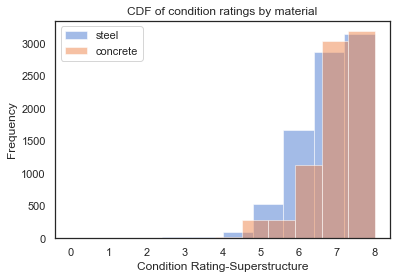

In [34]:
#Visualize CDF of the distributions to help determine if they are identical
steel['SUPERSTRUCTURE_COND_059'].plot(kind='hist',cumulative=True,alpha=0.5,label='steel')
concrete['SUPERSTRUCTURE_COND_059'].plot(kind='hist',cumulative=True,alpha=0.5,label='concrete')
plt.legend(loc='upper left')
plt.xlabel('Condition Rating-Superstructure')
plt.title('CDF of condition ratings by material')
plt.style.use('seaborn')
plt.show()

CDF appears to show the data follow different distributions as they differ significantly.

Hypothesis test

**H0**: Steel and Concrete have the same distribution of condition rating

**Ha**: Steel and Concrete do not have the same distribution of condition rating

In [35]:
# get data ready for chi-square test
new_index = np.arange(10)
steel_chi = steel['SUPERSTRUCTURE_COND_059'].value_counts().sort_index()
concrete_chi = concrete['SUPERSTRUCTURE_COND_059'].value_counts().sort_index()
steel_chi = steel_chi.reindex(new_index,axis='index',fill_value=1)
concrete_chi = concrete_chi.reindex(new_index,axis='index',fill_value=1)

In [36]:
# perform chi square test to see if steel and concrete come from the same distribution
stats.chisquare(steel_chi,concrete_chi)

Power_divergenceResult(statistic=748.6380559853192, pvalue=2.3992913210184065e-155)

With a very low p-value, we reject the hypothesis that the condition ratings for steel and concrete are distributed the same. The means are similarly not equal. This is interesting from a material standpoint because it may show that one material is more durable in the field than the other is. Let's generate confidence intervals for each. Keep in mind that given such a large dataset, statistical tests are almost certainly bound to reject the null hypothesis.

Since we have cleaned the data and therefore eliminated some potential values from the data set, we do not truly have a census of bridges in Georgia. Therefore, we can treat our dataset as a sample and use it to generate a confidence interval.

In [37]:
# mean of steel superstructure condition rating
conf_int(steel['SUPERSTRUCTURE_COND_059'],conf=95)

array([6.32232455, 6.38869482])

In [38]:
# mean of concrete superstructure condition rating
conf_int(concrete['SUPERSTRUCTURE_COND_059'],conf=95)

array([6.56900878, 6.62076537])

As expected the confidence intervals do not overlap, and this suggests that under the current maintenance structure as mandated by GDOT, and assuming the average age is identical, then concrete superstructures are more durable than steel. Steel mean age is slightly larger than concrete mean age, so this may account for the difference. Also the practical significance of this finding may not be important, as maximum difference in mean condition ratings at 95% is 0.3, only a slight edge!

## Hypothesis C

The next hypothesis we want to test is there any difference in the mean condition ratings by bridge location, i.e. do decks differ in condition from substructures, and so on, on average?

Hypothesis test

**H0**: There is no difference in the mean of the two groups

**Ha**: There is a difference in the mean of the two groups

In [39]:
from itertools import combinations
comb = combinations(conditions,2)
print('Test Difference in Means')
print('')
t_comb = np.empty(3)
p_comb = np.empty(3)
for index, item in enumerate(list(comb)):
    t_comb[index], p_comb[index] = stats.ttest_ind(data[item[0]],data[item[1]])
    print(item[0], 'and', item[1])
    print('Test Statistic:',t_comb[index])
    print('P-Value:',p_comb[index])
    print('')

Test Difference in Means

DECK_COND_058 and SUPERSTRUCTURE_COND_059
Test Statistic: -14.881925888190455
P-Value: 8.544200723159306e-50

DECK_COND_058 and SUBSTRUCTURE_COND_060
Test Statistic: 11.436686582851008
P-Value: 3.48603240099551e-30

SUPERSTRUCTURE_COND_059 and SUBSTRUCTURE_COND_060
Test Statistic: 24.513435118530452
P-Value: 1.463774728368288e-130



As expected, the means differ for each bridge location. We will generate confidence intervals to quantify the means.

In [40]:
for condition in conditions:
    print(condition)
    print(conf_int(data[condition],conf=99))
    print('')

DECK_COND_058
[6.52217899 6.56853863]

SUPERSTRUCTURE_COND_059
[6.71873263 6.77042857]

SUBSTRUCTURE_COND_060
[6.35675375 6.41256309]



General note on hypothesis testing: The sample sizes used for these tests are large, so the fact that we rejected the null hypothesis every time is not surprising. This does not mean that results are invalid. With larger sample sizes, it becomes easier to find even slight deviations between groups.

# Machine Learning

## Preprocessing

In [41]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

In [42]:
def plot_roc_curve(fpr, tpr): 
    ## plots roc curve based on false positive rate, and true positive rate
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [43]:
#Prepare list of feature variables
drop_list = ['STRUCTURE_KIND_043A','YEAR_BUILT_027']
features = data[feature_list].drop(drop_list,axis=1)
features.head()

,LAT_016,LONG_017,AGE,STRUCTURE_LEN_MT_049,elevation,DESIGN_LOAD_031,ROADWAY_WIDTH_MT_051,ADT_029,PERCENT_ADT_TRUCK_109,DEGREES_SKEW_034,HORR_CLR_MT_047
0,30462740.0,81323950.0,36.0,6.7,22.97,0.0,4.0,2.0,20.0,0.0,4.0
1,31330400.0,84053450.0,60.0,24.7,187.01,0.0,7.3,10.0,5.0,0.0,3.7
2,31325150.0,84054240.0,60.0,30.9,232.94,0.0,3.4,50.0,5.0,0.0,3.4
3,32182583.0,84503354.0,87.0,13.7,344.49,5.0,7.4,50.0,10.0,0.0,7.4
4,32262085.0,84435868.0,40.0,56.0,446.19,5.0,8.6,100.0,40.0,0.0,8.6


In [44]:
#Select proportional size of test data for train_test_split
ts = 0.25

**We will utilize nested cross validation to avoid over optimistic results**

## Principal Component Analysis

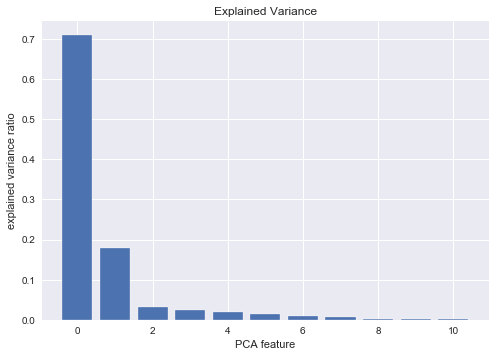

In [45]:
#initiate PCA handler
pca = PCA()
steps = [('scaler', RobustScaler()),('pca', pca)]
pipeline = Pipeline(steps)
pipeline.fit(features)
#number of pca components
f = range(pca.n_components_)
plt.bar(f, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('explained variance ratio')
plt.title('Explained Variance')
plt.show()

Only two features account for most of the variance in the data. Since we do not have a very high dimensional dataset, we will keep all features. But it is useful to know that only two are necessary for prediction.

In [46]:
pca.explained_variance_ratio_

array([0.70928663, 0.17980374, 0.03069178, 0.02343972, 0.01896787,
       0.0146656 , 0.00863255, 0.00763958, 0.00299905, 0.00212414,
       0.00174934])

## Model Selection Process

We select a variety of classifier models and regression models in the following code. We will use the classification models to predict the condition rating variables, which are discrete variables. We will also use regression models to predict sufficiency rating since it is a continuous variable.

In general, the model building process is patterned off of the following algorithm

1. Transform the data
2. Fit the data to the specified model using a GridSearch over hyperparameters.
3. Reduce overfitting by using cross-validation
4. Evaluate and plot model metrics

Even though our feature set is not well suited to regression, due to the fact that some features such as Design Load are more labels than continuous values, though the values do scale with load, we will still perform Regression, but will get better results with Classification.

## Regression

### Ridge, Lasso and Elastic Net Regression

In [47]:
#Ridge Regression to predict Sufficiency Rating
steps = [('scaler', QuantileTransformer()),('Ridge', Ridge())]
params = {'Ridge__alpha':np.arange(0.5,100.5,0.5)}
pipeline = Pipeline(steps)
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data['SUFFICIENCY_RATING'],test_size=ts,random_state=42)

In [48]:
grid = GridSearchCV(pipeline, param_grid=params, cv=5)
grid.fit(Xtrain,ytrain)
print('Ridge Cross Validated R^2:',np.mean(cross_val_score(grid,Xtest,ytest)))

Ridge Cross Validated R^2: 0.5419777383451827


In [49]:
grid.best_params_

{'Ridge__alpha': 3.0}

It appears that our data cannot be well modeled using a simple linear model. The more complex models that take into account the non-linearity of our data will be better suited for model construction. Our current model is only nominally better than a coin toss. Let us try a few more linear models to make sure.

In [50]:
# Lasso
alpha = 0.5
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(Xtrain, ytrain).predict(Xtest)
r2_score_lasso = r2_score(ytest, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.497154


In [51]:
#ElasticNet
enet = ElasticNet(alpha=0.5, l1_ratio=0.7)

y_pred_enet = enet.fit(Xtrain, ytrain).predict(Xtest)
r2_score_enet = r2_score(ytest, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.5, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.496999


Lasso and ElasticNet are slightly worse performers than a tuned Ridge Regression model, so there will be very little gain from tuning these models. We will move on to other models to improve performance.

### Gradient Boosting

In [52]:
params = {'n_estimators':1500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gboost = GradientBoostingRegressor(**params)
gboost.fit(Xtrain, ytrain)
mse = mean_squared_error(ytest, gboost.predict(Xtest))
print("MSE: %.4f" % mse)
print('First Run Score:',gboost.score(Xtest,ytest))
print('Gradient Boosting Cross Validated R^2:',np.mean(cross_val_score(gboost,Xtest,ytest,cv=3)))

MSE: 129.9488
First Run Score: 0.6660553206259462
Gradient Boosting Cross Validated R^2: 0.6012908580805739


Gradient Boosting has performed significantly better than Ridge Regression. Let's try another ensemble method, Random Forest.

### Random Forest Regression

In [53]:
# Instantiate model with 2500 decision trees
rf = RandomForestRegressor(n_estimators=2500, max_features=11, random_state=42)
#split data into training and testing groups
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data['SUFFICIENCY_RATING'],test_size=ts,random_state=42)
# Train the model on training data
rf.fit(Xtrain, ytrain)
ytest_score = np.reshape(np.array(ytest),[-1,1])
print('Cross Validated RF R^2:',np.mean(cross_val_score(rf,Xtest,ytest_score)))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


Cross Validated RF R^2: 0.6148579496638986


In [54]:
#Find feature importances in the Random Forest Model
rf_feature_list_reg = pd.DataFrame(list(zip(features.columns,rf.feature_importances_)),columns=['Feature','Importance'])
rf_feature_list_reg.sort_values(by='Importance',ascending=False).reset_index(drop=True)

,Feature,Importance
0,DESIGN_LOAD_031,0.370674
1,AGE,0.177564
2,HORR_CLR_MT_047,0.086236
3,ADT_029,0.072568
4,ROADWAY_WIDTH_MT_051,0.072052
5,LAT_016,0.061234
6,STRUCTURE_LEN_MT_049,0.050838
7,LONG_017,0.047347
8,elevation,0.041785
9,DEGREES_SKEW_034,0.012531


Surprisingly, Design Load is more effective in prediction than Age. This was unexpected and seems to disconfirm our hypotheses that Age is the most important factor and Design Load is inconsequential.

## Classification

In [55]:
def getrocdata(clf,X_test,y_test):
    #calculate ROC curve and AUC of classifier
    
    y_pred_proba = clf.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1])
    auc_ret = auc(fpr,tpr)
    print('Area under curve:',auc)
    return fpr, tpr, auc_ret

### Logistic Regression

Build classifier that predicts which of 3 classes (Good=2, Fair=1, Poor=0) the bridge is.

In [56]:
steps = [('scaler', QuantileTransformer(output_distribution='normal')),('Logit', LogisticRegression(multi_class='ovr',solver='newton-cg'))]
C_range = [0.5,0.75,1,1.5,10,100,1000]
params = {'Logit__C':C_range}
pipeline = Pipeline(steps)
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data['bridge_class3'],test_size=ts,random_state=42)

In [57]:
grid_logit_3 = GridSearchCV(pipeline, params, cv=7)
grid_logit_3.fit(Xtrain,ytrain)
ypred = grid_logit_3.predict(Xtest)
print('Cross Validated Score:',np.mean(cross_val_score(grid_logit_3,Xtest,ytest,cv=3)))

Cross Validated Score: 0.7456549453175129


In [58]:
grid_logit_3.best_params_

{'Logit__C': 0.5}

Confusion matrix, without normalization
[[ 637  250    0]
 [ 178 1060    0]
 [   2  122    0]]


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


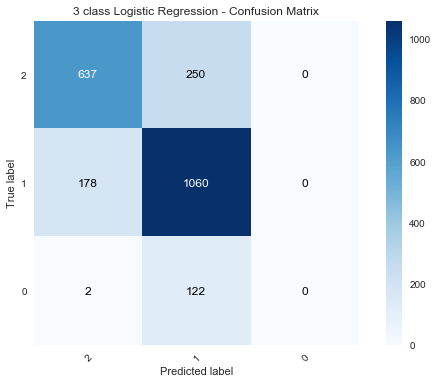

In [59]:
classes = np.flip(np.sort(data['bridge_class3'].unique()))
plot_confusion_matrix(ytest, ypred, classes,
                          normalize=False,
                          title='3 class Logistic Regression - Confusion Matrix',
                          cmap=plt.cm.Blues)


It appears our 3 class model is not good at predicting when a bridge will receive a poor condition rating. Let's build another Logistic Regression classifier that gives the bridge a pass fail score based on the minimum condition rating.

In [60]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data['bridge_class2'],test_size=ts,random_state=42)

In [61]:
steps = [('scaler', QuantileTransformer(output_distribution='normal')),('Logit', LogisticRegression())]
C_range = [0.25,0.5,0.75,1,1.5,10,100]
params = {'Logit__C':C_range}
pipeline = Pipeline(steps)
grid_logit_2 = GridSearchCV(pipeline, params, cv=5)
grid_logit_2.fit(Xtrain,ytrain)
ypred_proba = grid_logit_2.predict_proba(Xtest)
ypred = grid_logit_2.predict(Xtest)
print('Cross Validated Score:',np.mean(cross_val_score(grid_logit_2,Xtest,ytest)))

Cross Validated Score: 0.9430825654801165


Our mean accuracy drastically improved with the binary problem. This is a cautious result due to class imbalance. We need more model metrics to truly evaluate this classifier.

In [62]:
grid_logit_2.best_params_

{'Logit__C': 0.5}

In [63]:
fpr, tpr, auc_logit = getrocdata(grid_logit_2,Xtest,ytest)

Area under curve: <function auc at 0x1a20fd8f28>


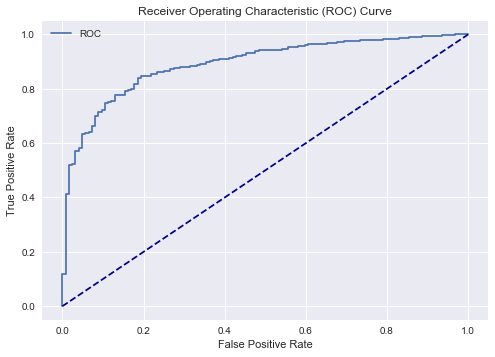

In [64]:
fpr, tpr, thresh = roc_curve(ytest, ypred_proba[:,1])
plot_roc_curve(fpr, tpr)

In [65]:
auc_logit

0.8915370018975333

Confusion matrix, without normalization
[[2120    5]
 [ 119    5]]


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


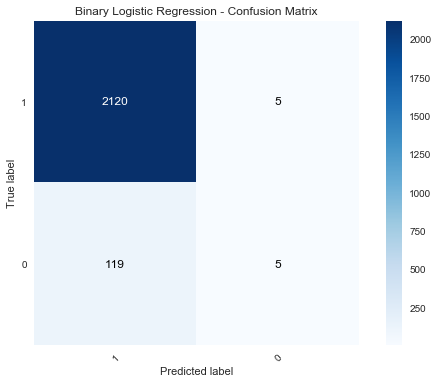

In [66]:
classes = data['bridge_class2'].unique().astype(int)
plot_confusion_matrix(ytest, ypred, classes,
                          normalize=False,
                          title='Binary Logistic Regression - Confusion Matrix',
                          cmap=plt.cm.Blues)

In [67]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(ytest,ypred)

(array([0.5       , 0.94685127]),
 array([0.04032258, 0.99764706]),
 array([0.07462687, 0.9715857 ]),
 array([ 124, 2125]))

Examining the precision and recall for the 0 class shows very poor performance, the model is not good at distinguishing bridges that pass and bridges that fail. Let's try the full multi class problem.

In [68]:
steps = [('scaler', QuantileTransformer(output_distribution='normal')),('Logit', LogisticRegression(multi_class='ovr',solver='newton-cg'))]
C_range = [0.5,0.75,1,1.5,10,100]
params = {'Logit__C':C_range}
pipeline = Pipeline(steps)
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data[conditions[0]],test_size=ts,random_state=42)
grid_logit_all = GridSearchCV(pipeline,params,cv=5)
grid_logit_all.fit(Xtrain,ytrain)
print('Cross Validated Score:',np.mean(cross_val_score(grid_logit_all,Xtest,ytest)))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

Cross Validated Score: 0.5656182307253959


### Support Vector Machine Classifier

In [69]:
#SVM pipeline using multiple kernels
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data[conditions[0]].astype(int),test_size=ts,random_state=42)
steps = [('scaler', QuantileTransformer(output_distribution='normal')),('SVC', SVC(kernel='rbf'))]
params = {'SVC__C':C_range}
pipeline_svm = Pipeline(steps)
grid_svm = GridSearchCV(pipeline_svm, params, cv=3)
grid_svm.fit(Xtrain,ytrain)
print("Cross Validated Score:",np.mean(cross_val_score(grid_svm,Xtest,ytest)))
ypred = grid_svm.predict(Xtest)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

Cross Validated Score: 0.5784972262864321


Confusion matrix, without normalization
[[ 69 106  20   0   0   0   0   0   0]
 [ 28 896 185   4   0   0   0   0   0]
 [  0 271 389  25   0   0   0   0   0]
 [  0  28 164  29   0   0   0   0   0]
 [  0   1  20   9   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]]


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


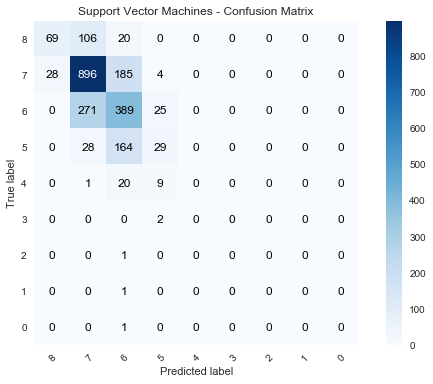

In [70]:
classes = np.flip(np.sort(data[conditions[0]].unique().astype(int)))
plot_confusion_matrix(ytest, ypred, classes,
                          normalize=False,
                          title='Support Vector Machines - Confusion Matrix',
                          cmap=plt.cm.Blues)

### Random Forest Classification

In [71]:
#Random Forest model
Xtrain, Xtest, ytrain, ytest = train_test_split(features,data[conditions[0]].astype(int),test_size=ts,random_state=42)
clf_rf = RandomForestClassifier()
grid_param = {  
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
clf_rf_grid = GridSearchCV(estimator=clf_rf,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5)
clf_rf_grid.fit(Xtrain,ytrain)
ypred = clf_rf_grid.predict(Xtest)
print('Cross Validated Score:',np.mean(cross_val_score(clf_rf_grid,Xtest,ytest)))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

Cross Validated Score: 0.6153705532423069


In [72]:
clf_rf_grid.best_params_

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 1000}

Confusion matrix, without normalization
[[ 97  82  15   1   0   0   0   0   0]
 [ 43 878 173  19   0   0   0   0   0]
 [  2 240 386  57   0   0   0   0   0]
 [  1  21 129  69   1   0   0   0   0]
 [  0   1  12  17   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]]


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


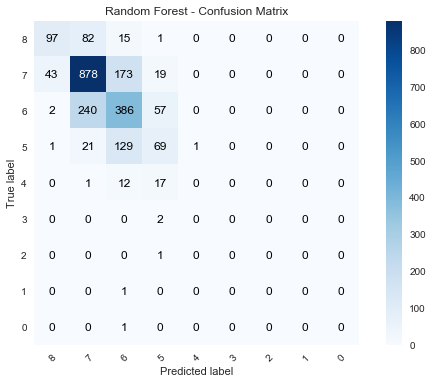

In [73]:
plot_confusion_matrix(ytest, ypred, classes,
                          normalize=False,
                          title='Random Forest - Confusion Matrix',
                          cmap=plt.cm.Blues)

In [74]:
#Print Feature Importances for Random Forest model
rf_feature_list = pd.DataFrame(list(zip(features.columns,clf_rf_grid.best_estimator_.feature_importances_)),columns=['Feature','Importance'])
rf_feature_list.sort_values(by='Importance',ascending=False).reset_index(drop=True)

,Feature,Importance
0,AGE,0.223155
1,LAT_016,0.123251
2,LONG_017,0.115034
3,elevation,0.099951
4,STRUCTURE_LEN_MT_049,0.096552
5,ADT_029,0.089079
6,HORR_CLR_MT_047,0.077605
7,ROADWAY_WIDTH_MT_051,0.076542
8,DESIGN_LOAD_031,0.043113
9,DEGREES_SKEW_034,0.035516


It appears that age is important in both regression and classification and is the most important feature for our models, since it is near the top for both regression and classification. Elevation is significant in classification, and Design load is only significant for regression. We have confirmed that age is the most important predictor variable, and disconfirmed that Design Load and Elevation are not important for our models.

# Conclusion

In conclusion, given our limited feature set by design, the results were good overall. The classification models outperformed the regression models on average. Also, in general, ensemble methods provided better performance over the basic models. With this analysis, we have shown that we can meaningfully predict the outcomes of bridge sufficiency ratings and bridge condition ratings in the state of Georgia using easily obtainable data and a variety of machine learning methods. This work will potentially have a great impact on the safety and economy of the state of Georgia by leveraging available data to understand and control the bridge infrastructure of the state.

# Future Work/Next Steps

Future Steps include:

1. Try model stacking to improve regression performance
2. Include more features from FHWA dataset
3. Improve scaling of Design_Load variable
4. Expand dataset to other states in the USA
5. Deal with class imbalance in the binary problem.

Combining datasets from multiple states may not be effective as each state has a different maintenance program, different inspectors, and different design criteria that may throw off results.

In [75]:
#Notebook Total Run Time
end = time.time()
print('Program Run Time (s):',round(end - start,2))
print('Program Run Time (m):',round((end-start)/60,2))

Program Run Time (s): 1578.22
Program Run Time (m): 26.3
